In [1]:

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np




In [26]:


h1=5
w1=1

newpath = os.path.join(os.getcwd(),'SteinFigures/h'+repr(h1))
if not os.path.exists(newpath):
        os.makedirs(newpath)

def force(x):
    return -h1*4*(x**2-w1)*x;
def energy(x):
    return h1*(x**2-w1)**2

nrSteps = 10000

x = np.ones(nrSteps)
p = np.random.randn(nrSteps)
dt=0.01
gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))


pn = p[0]
xn = x[0]
    
f=force(xn)

for n in range(nrSteps-1):
        
        if n % 10 ==0:
            pn = p[0]
            xn = x[0]
        
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f=force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        p[n+1] = pn
        x[n+1] = xn
    


In [3]:
# take a gaussian as initial conditions.
x = np.random.randn(nrSteps) * 0.1 + 0.8

q_density = 1.0/np.sqrt(2*np.pi*0.1**2) * np.exp(-(x-.2)**2 / (2*0.1**2))

X0=x

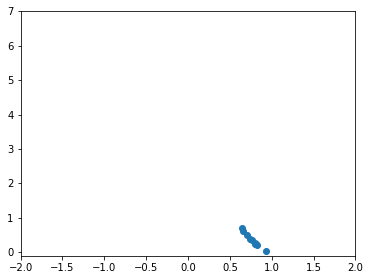

In [4]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x, energy(x))
    ax.set_xlim([-2,2])
    ax.set_ylim([-0.1,7])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None)

#  Stein force

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def compute_stein_force(XL, leader_set):
   
    my_force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    force_resh = np.asarray(my_force)
    # create numpy array from the list XL which has also units
    
    # choose leader particles using the index set leader_set
    X_leader = XL[leader_set]
   
    # kernel scaling parameter
    h=0.1
    
    distances = cdist(XL[:,np.newaxis], X_leader[:,np.newaxis])
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel, force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # add force unit and divide by kT
    #f_MDforce = f_MDforce * model.force_unit / smpl.kT
    f_MDforce = f_MDforce  / kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel, X_leader)
    f_der += 2.0/h * np.sum(kernel,1) * XL
    f_der = f_der / len(leader_set)
    # add unit
    #f_der = f_der * model.x_unit**(-1)
    
    grad_force = (-2.0/h*XL*np.dot(kernel, force_resh) +2.0/h * np.dot(kernel, X_leader*force_resh)) / kT
    grad_force += 2.0/h*np.sum(kernel,1)
    grad_force -= 4.0/(h**2) * (XL**2 * np.sum(kernel,1) -2.0*XL * np.dot(kernel, X_leader) + np.dot(kernel, X_leader**2))
    grad_force = grad_force / len(leader_set)
    
    return f_MDforce + f_der, grad_force

#def update_weights(XL, leader_set, q_dens):
    





# Iterate Stein

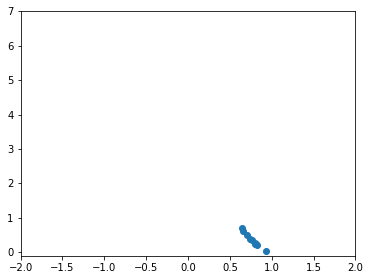

Stein iteration 0


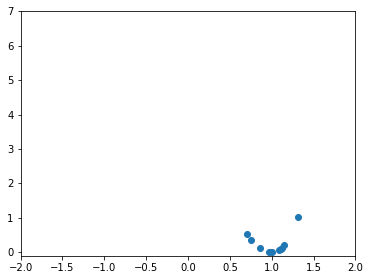

Stein iteration 50


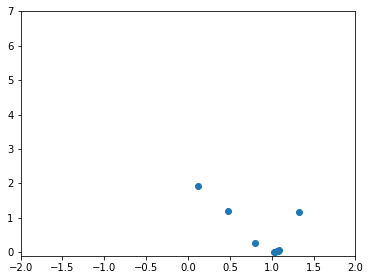

Stein iteration 100


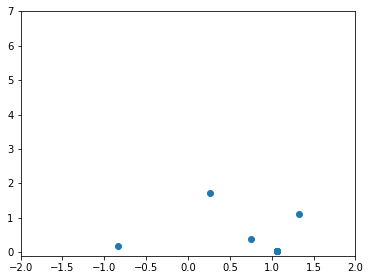

Stein iteration 150


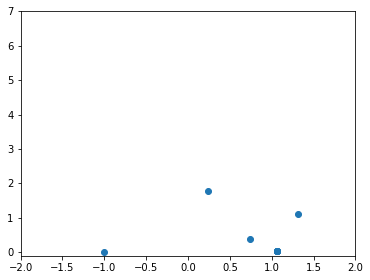

Stein iteration 200


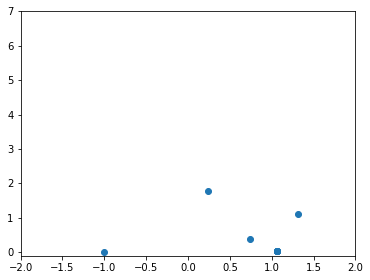

Stein iteration 250


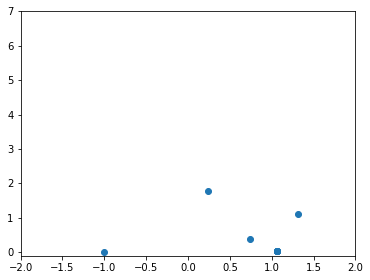

Stein iteration 300


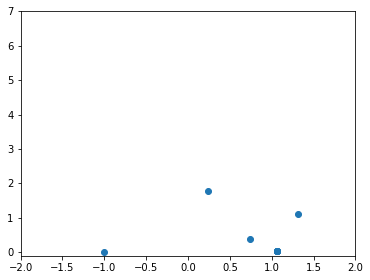

Stein iteration 350


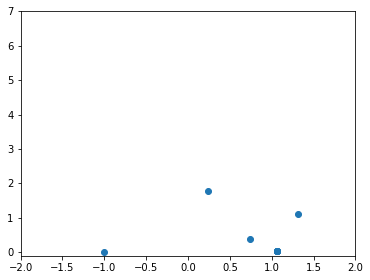

Stein iteration 400


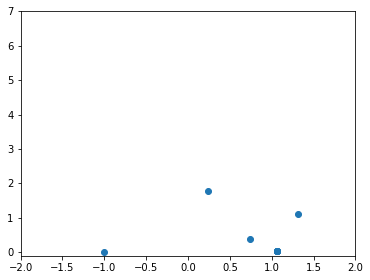

Stein iteration 450


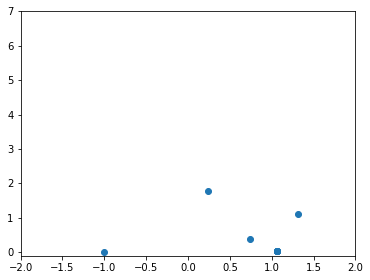

Stein iteration 500


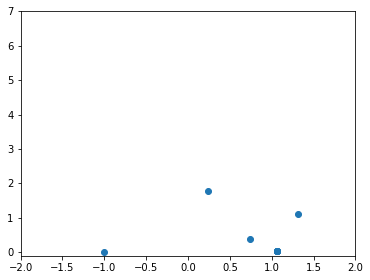

Stein iteration 550


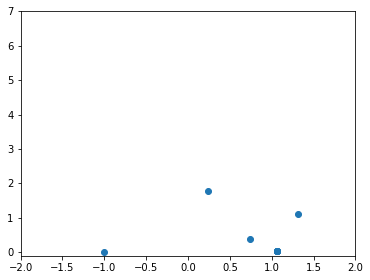

Stein iteration 600


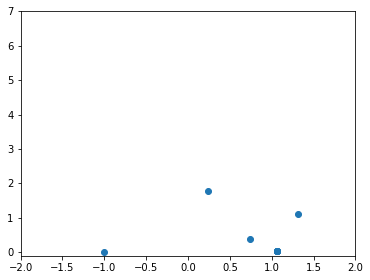

Stein iteration 650


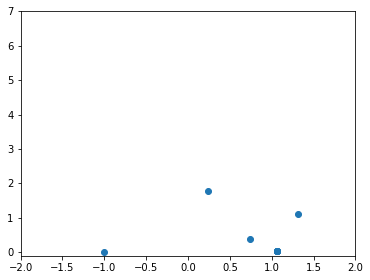

Stein iteration 700


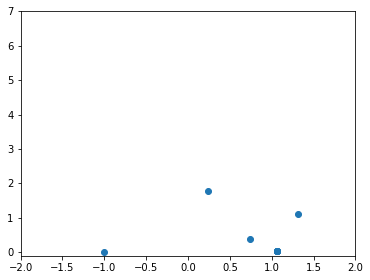

Stein iteration 750


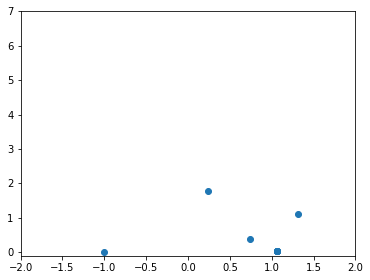

Stein iteration 800


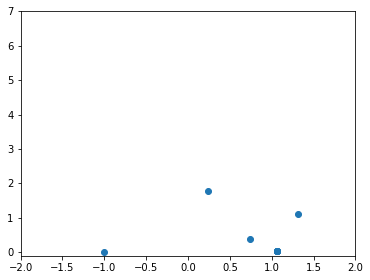

Stein iteration 850


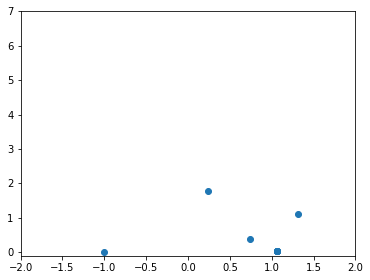

Stein iteration 900


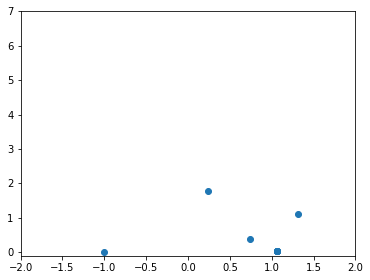

Stein iteration 950


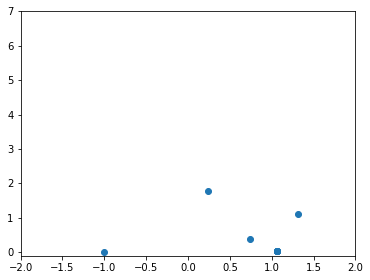

In [6]:
numberOfSteinSteps = 1000#50000

X_short = np.copy(X0)

epsilon_step=0.1

# choose leader set
numberOfLeaderParticles = int(0.9*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/20)
moditfig = int(numberOfSteinSteps/20)
KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)

states_evolution_stein =[]

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f, grad_force = compute_stein_force(XL,leader_set)
    XL = (XL + epsilon_step * f)#/mass );
    q =  np.copy(XL)
    q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    weights = np.exp(-energy(q)) / q_density
    KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    Obs_average[ns] = np.mean(q)
    states_evolution_stein.append(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

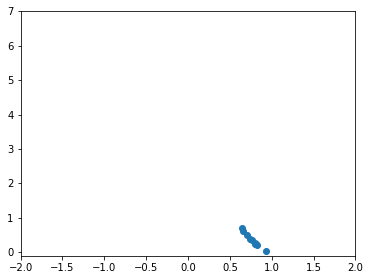

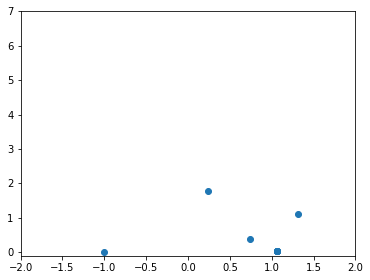

In [7]:
plotSampling_fromData(X0,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')


In [8]:
# from scipy.integrate import quadrature
# def fit_distribution(x):
#     x = x[:,0,0]
#     Z = 0.5725340617#quadrature(lambda y : np.exp(-energy(y)), -1000, 1000)[1]
#     xx = np.linspace(-2,2,100)
    
#     fig = plt.figure(figsize=(6,4.5))
#     ax = fig.add_subplot(111)
#     ax.hist(x, 50, density=True);
#     ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
   
#     plt.show()

In [9]:
# fit_distribution(q)


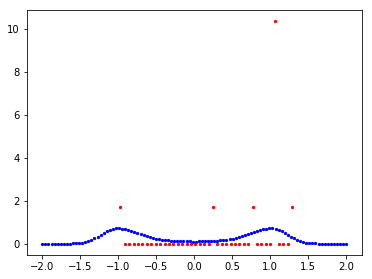

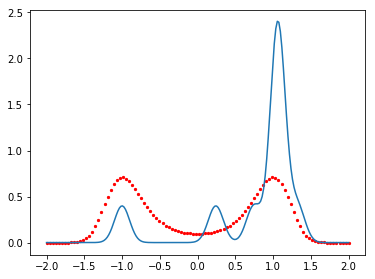

In [10]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xx = np.linspace(-2,2,100)
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
ax.scatter(xx, np.exp(- energy(xx))/Z , c='b', s=5)
ax.scatter(bin_centers, data , c='r', s=5)
plt.show()

from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()

In [11]:
Z = 1.973732150#0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X_short))
print(np.mean(q))
print('************')

print('E[V(x)] = .4172545129')#0.5247724179')
print(np.mean(energy(X_short)))
print(np.mean(energy(q)))
print('************')

print('E[-f(x)*x] = 1')
print(np.mean((-force(X_short)* X_short)))
print((np.mean(-force(q)* q)))

Z=1.97373215
E[x] = 0
0.768349642104
0.767797267647
************
E[V(x)] = .4172545129
0.357140434785
0.346731753068
************
E[-f(x)*x] = 1
-1.79546731782
1.48430682248


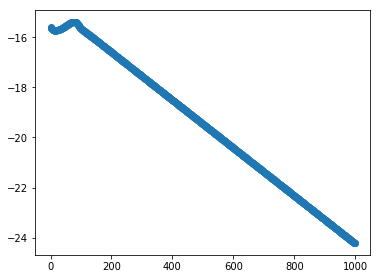

In [12]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), -KL)
#ax.set_ylim(1e-4, 1)
plt.show()

In [13]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/stein'
# fps = 1000
# file_list = glob.glob('SteinFigures/'+'/*.png') # Get all the pngs in the current directory
# list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

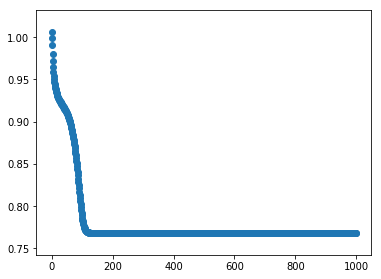

In [14]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_yscale('log')
ax.scatter(np.arange(numberOfSteinSteps), Obs_average)
#ax.set_ylim(1e-4, 1)
plt.show()

# Parallel Langevin steps

In [15]:
#x = np.ones(nrSteps)
#p = np.random.randn(nrSteps)

def Langevin_step(x, p, dt):
    
    gamma = 1
    kT = 1
    a = np.exp(-gamma * (dt))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))
    
    for n in range(len(x)):
        
        xn=x[n]
        pn=p[n]
        
        f = force(xn)
      
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f = force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        x[n]=xn
        p[n]=pn
        
    return x, p


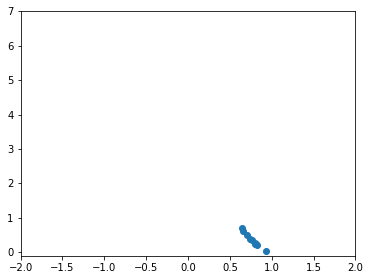

Langevin iteration 0
(10,)


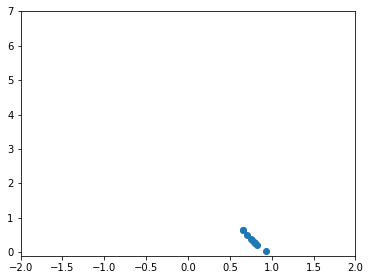

Langevin iteration 1
(10,)
Langevin iteration 2
(10,)
Langevin iteration 3
(10,)
Langevin iteration 4
(10,)
Langevin iteration 5
(10,)
Langevin iteration 6
(10,)
Langevin iteration 7
(10,)
Langevin iteration 8
(10,)
Langevin iteration 9
(10,)
Langevin iteration 10
(10,)


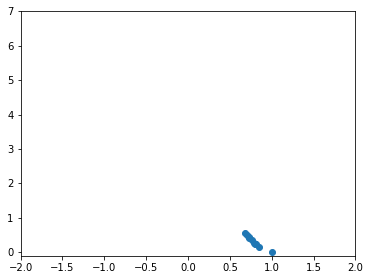

Langevin iteration 11
(10,)
Langevin iteration 12
(10,)
Langevin iteration 13
(10,)
Langevin iteration 14
(10,)
Langevin iteration 15
(10,)
Langevin iteration 16
(10,)
Langevin iteration 17
(10,)
Langevin iteration 18
(10,)
Langevin iteration 19
(10,)
Langevin iteration 20
(10,)


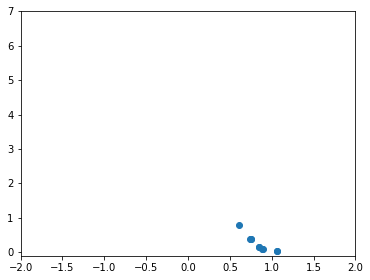

Langevin iteration 21
(10,)
Langevin iteration 22
(10,)
Langevin iteration 23
(10,)
Langevin iteration 24
(10,)
Langevin iteration 25
(10,)
Langevin iteration 26
(10,)
Langevin iteration 27
(10,)
Langevin iteration 28
(10,)
Langevin iteration 29
(10,)
Langevin iteration 30
(10,)


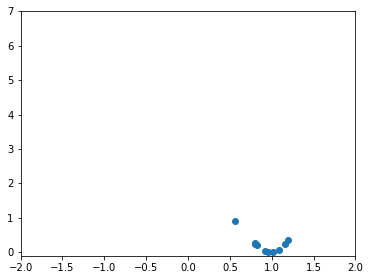

Langevin iteration 31
(10,)
Langevin iteration 32
(10,)
Langevin iteration 33
(10,)
Langevin iteration 34
(10,)
Langevin iteration 35
(10,)
Langevin iteration 36
(10,)
Langevin iteration 37
(10,)
Langevin iteration 38
(10,)
Langevin iteration 39
(10,)
Langevin iteration 40
(10,)


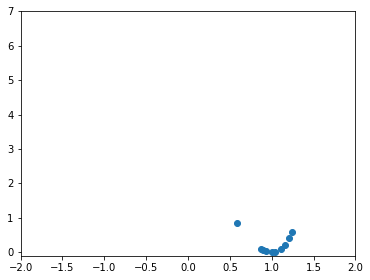

Langevin iteration 41
(10,)
Langevin iteration 42
(10,)
Langevin iteration 43
(10,)
Langevin iteration 44
(10,)
Langevin iteration 45
(10,)
Langevin iteration 46
(10,)
Langevin iteration 47
(10,)
Langevin iteration 48
(10,)
Langevin iteration 49
(10,)
Langevin iteration 50
(10,)


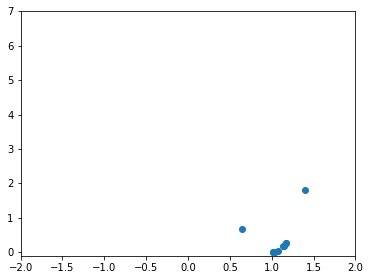

Langevin iteration 51
(10,)
Langevin iteration 52
(10,)
Langevin iteration 53
(10,)
Langevin iteration 54
(10,)
Langevin iteration 55
(10,)
Langevin iteration 56
(10,)
Langevin iteration 57
(10,)
Langevin iteration 58
(10,)
Langevin iteration 59
(10,)
Langevin iteration 60
(10,)


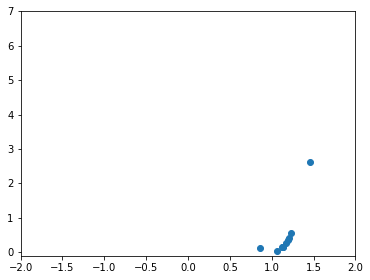

Langevin iteration 61
(10,)
Langevin iteration 62
(10,)
Langevin iteration 63
(10,)
Langevin iteration 64
(10,)
Langevin iteration 65
(10,)
Langevin iteration 66
(10,)
Langevin iteration 67
(10,)
Langevin iteration 68
(10,)
Langevin iteration 69
(10,)
Langevin iteration 70
(10,)


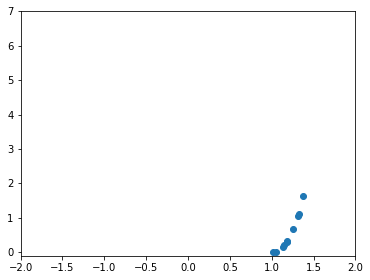

Langevin iteration 71
(10,)
Langevin iteration 72
(10,)
Langevin iteration 73
(10,)
Langevin iteration 74
(10,)
Langevin iteration 75
(10,)
Langevin iteration 76
(10,)
Langevin iteration 77
(10,)
Langevin iteration 78
(10,)
Langevin iteration 79
(10,)
Langevin iteration 80
(10,)


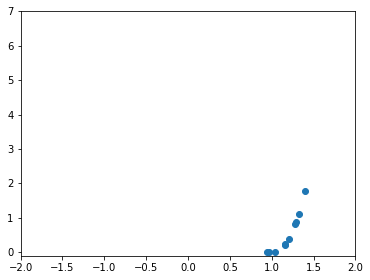

Langevin iteration 81
(10,)
Langevin iteration 82
(10,)
Langevin iteration 83
(10,)
Langevin iteration 84
(10,)
Langevin iteration 85
(10,)
Langevin iteration 86
(10,)
Langevin iteration 87
(10,)
Langevin iteration 88
(10,)
Langevin iteration 89
(10,)
Langevin iteration 90
(10,)


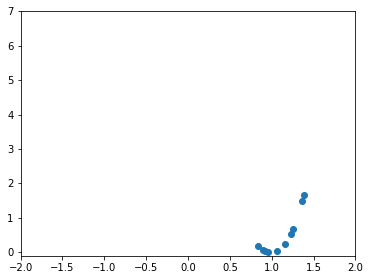

Langevin iteration 91
(10,)
Langevin iteration 92
(10,)
Langevin iteration 93
(10,)
Langevin iteration 94
(10,)
Langevin iteration 95
(10,)
Langevin iteration 96
(10,)
Langevin iteration 97
(10,)
Langevin iteration 98
(10,)
Langevin iteration 99
(10,)
Langevin iteration 100
(10,)


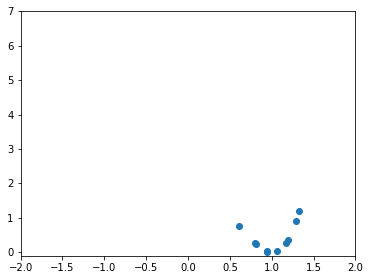

Langevin iteration 101
(10,)
Langevin iteration 102
(10,)
Langevin iteration 103
(10,)
Langevin iteration 104
(10,)
Langevin iteration 105
(10,)
Langevin iteration 106
(10,)
Langevin iteration 107
(10,)
Langevin iteration 108
(10,)
Langevin iteration 109
(10,)
Langevin iteration 110
(10,)


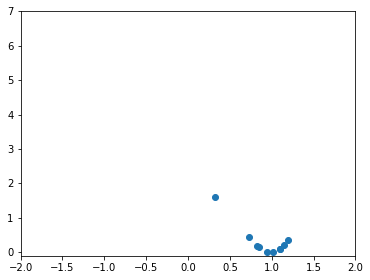

Langevin iteration 111
(10,)
Langevin iteration 112
(10,)
Langevin iteration 113
(10,)
Langevin iteration 114
(10,)
Langevin iteration 115
(10,)
Langevin iteration 116
(10,)
Langevin iteration 117
(10,)
Langevin iteration 118
(10,)
Langevin iteration 119
(10,)
Langevin iteration 120
(10,)


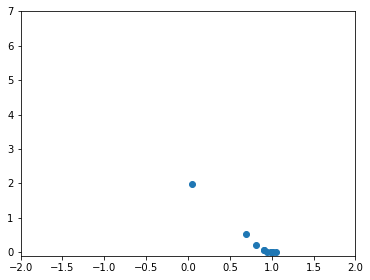

Langevin iteration 121
(10,)
Langevin iteration 122
(10,)
Langevin iteration 123
(10,)
Langevin iteration 124
(10,)
Langevin iteration 125
(10,)
Langevin iteration 126
(10,)
Langevin iteration 127
(10,)
Langevin iteration 128
(10,)
Langevin iteration 129
(10,)
Langevin iteration 130
(10,)


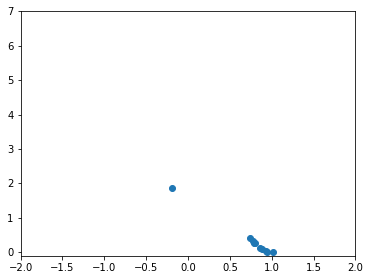

Langevin iteration 131
(10,)
Langevin iteration 132
(10,)
Langevin iteration 133
(10,)
Langevin iteration 134
(10,)
Langevin iteration 135
(10,)
Langevin iteration 136
(10,)
Langevin iteration 137
(10,)
Langevin iteration 138
(10,)
Langevin iteration 139
(10,)
Langevin iteration 140
(10,)


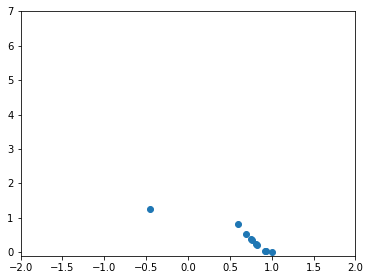

Langevin iteration 141
(10,)
Langevin iteration 142
(10,)
Langevin iteration 143
(10,)
Langevin iteration 144
(10,)
Langevin iteration 145
(10,)
Langevin iteration 146
(10,)
Langevin iteration 147
(10,)
Langevin iteration 148
(10,)
Langevin iteration 149
(10,)
Langevin iteration 150
(10,)


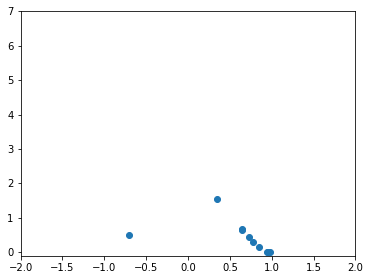

Langevin iteration 151
(10,)
Langevin iteration 152
(10,)
Langevin iteration 153
(10,)
Langevin iteration 154
(10,)
Langevin iteration 155
(10,)
Langevin iteration 156
(10,)
Langevin iteration 157
(10,)
Langevin iteration 158
(10,)
Langevin iteration 159
(10,)
Langevin iteration 160
(10,)


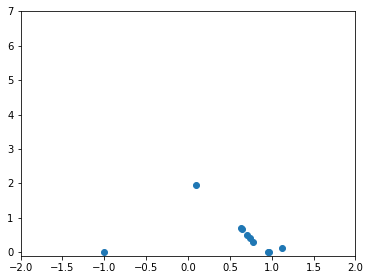

Langevin iteration 161
(10,)
Langevin iteration 162
(10,)
Langevin iteration 163
(10,)
Langevin iteration 164
(10,)
Langevin iteration 165
(10,)
Langevin iteration 166
(10,)
Langevin iteration 167
(10,)
Langevin iteration 168
(10,)
Langevin iteration 169
(10,)
Langevin iteration 170
(10,)


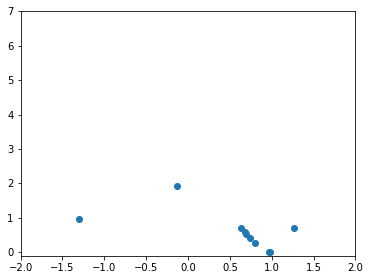

Langevin iteration 171
(10,)
Langevin iteration 172
(10,)
Langevin iteration 173
(10,)
Langevin iteration 174
(10,)
Langevin iteration 175
(10,)
Langevin iteration 176
(10,)
Langevin iteration 177
(10,)
Langevin iteration 178
(10,)
Langevin iteration 179
(10,)
Langevin iteration 180
(10,)


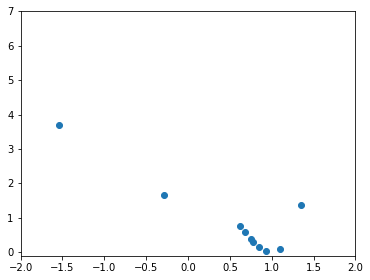

Langevin iteration 181
(10,)
Langevin iteration 182
(10,)
Langevin iteration 183
(10,)
Langevin iteration 184
(10,)
Langevin iteration 185
(10,)
Langevin iteration 186
(10,)
Langevin iteration 187
(10,)
Langevin iteration 188
(10,)
Langevin iteration 189
(10,)
Langevin iteration 190
(10,)


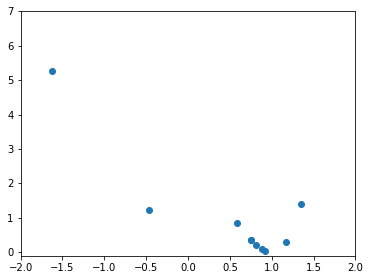

Langevin iteration 191
(10,)
Langevin iteration 192
(10,)
Langevin iteration 193
(10,)
Langevin iteration 194
(10,)
Langevin iteration 195
(10,)
Langevin iteration 196
(10,)
Langevin iteration 197
(10,)
Langevin iteration 198
(10,)
Langevin iteration 199
(10,)
Langevin iteration 200
(10,)


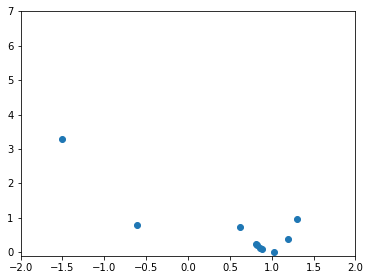

Langevin iteration 201
(10,)
Langevin iteration 202
(10,)
Langevin iteration 203
(10,)
Langevin iteration 204
(10,)
Langevin iteration 205
(10,)
Langevin iteration 206
(10,)
Langevin iteration 207
(10,)
Langevin iteration 208
(10,)
Langevin iteration 209
(10,)
Langevin iteration 210
(10,)


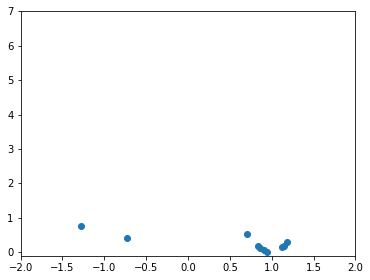

Langevin iteration 211
(10,)
Langevin iteration 212
(10,)
Langevin iteration 213
(10,)
Langevin iteration 214
(10,)
Langevin iteration 215
(10,)
Langevin iteration 216
(10,)
Langevin iteration 217
(10,)
Langevin iteration 218
(10,)
Langevin iteration 219
(10,)
Langevin iteration 220
(10,)


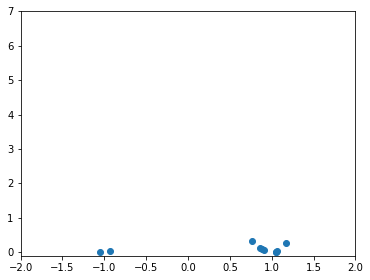

Langevin iteration 221
(10,)
Langevin iteration 222
(10,)
Langevin iteration 223
(10,)
Langevin iteration 224
(10,)
Langevin iteration 225
(10,)
Langevin iteration 226
(10,)
Langevin iteration 227
(10,)
Langevin iteration 228
(10,)
Langevin iteration 229
(10,)
Langevin iteration 230
(10,)


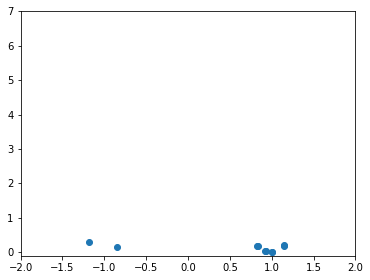

Langevin iteration 231
(10,)
Langevin iteration 232
(10,)
Langevin iteration 233
(10,)
Langevin iteration 234
(10,)
Langevin iteration 235
(10,)
Langevin iteration 236
(10,)
Langevin iteration 237
(10,)
Langevin iteration 238
(10,)
Langevin iteration 239
(10,)
Langevin iteration 240
(10,)


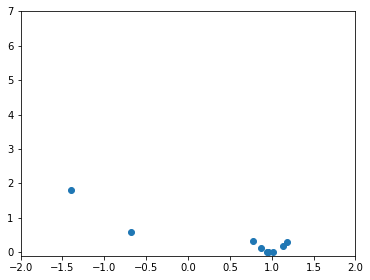

Langevin iteration 241
(10,)
Langevin iteration 242
(10,)
Langevin iteration 243
(10,)
Langevin iteration 244
(10,)
Langevin iteration 245
(10,)
Langevin iteration 246
(10,)
Langevin iteration 247
(10,)
Langevin iteration 248
(10,)
Langevin iteration 249
(10,)
Langevin iteration 250
(10,)


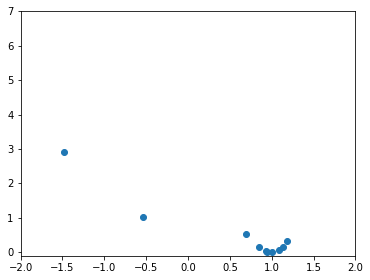

Langevin iteration 251
(10,)
Langevin iteration 252
(10,)
Langevin iteration 253
(10,)
Langevin iteration 254
(10,)
Langevin iteration 255
(10,)
Langevin iteration 256
(10,)
Langevin iteration 257
(10,)
Langevin iteration 258
(10,)
Langevin iteration 259
(10,)
Langevin iteration 260
(10,)


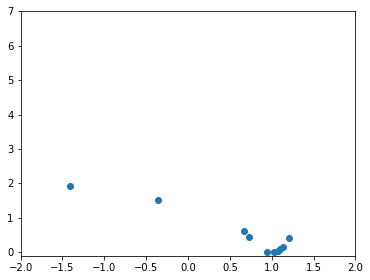

Langevin iteration 261
(10,)
Langevin iteration 262
(10,)
Langevin iteration 263
(10,)
Langevin iteration 264
(10,)
Langevin iteration 265
(10,)
Langevin iteration 266
(10,)
Langevin iteration 267
(10,)
Langevin iteration 268
(10,)
Langevin iteration 269
(10,)
Langevin iteration 270
(10,)


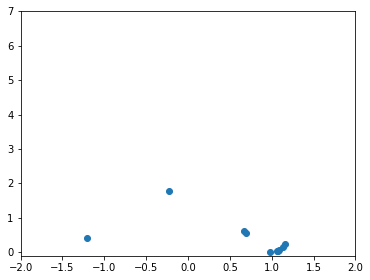

Langevin iteration 271
(10,)
Langevin iteration 272
(10,)
Langevin iteration 273
(10,)
Langevin iteration 274
(10,)
Langevin iteration 275
(10,)
Langevin iteration 276
(10,)
Langevin iteration 277
(10,)
Langevin iteration 278
(10,)
Langevin iteration 279
(10,)
Langevin iteration 280
(10,)


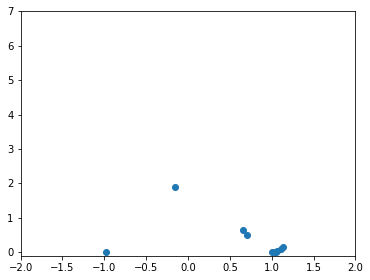

Langevin iteration 281
(10,)
Langevin iteration 282
(10,)
Langevin iteration 283
(10,)
Langevin iteration 284
(10,)
Langevin iteration 285
(10,)
Langevin iteration 286
(10,)
Langevin iteration 287
(10,)
Langevin iteration 288
(10,)
Langevin iteration 289
(10,)
Langevin iteration 290
(10,)


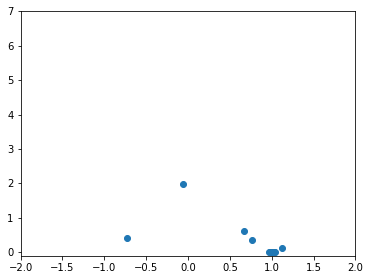

Langevin iteration 291
(10,)
Langevin iteration 292
(10,)
Langevin iteration 293
(10,)
Langevin iteration 294
(10,)
Langevin iteration 295
(10,)
Langevin iteration 296
(10,)
Langevin iteration 297
(10,)
Langevin iteration 298
(10,)
Langevin iteration 299
(10,)
Langevin iteration 300
(10,)


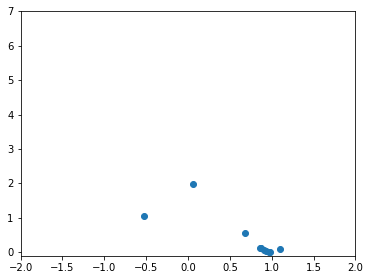

Langevin iteration 301
(10,)
Langevin iteration 302
(10,)
Langevin iteration 303
(10,)
Langevin iteration 304
(10,)
Langevin iteration 305
(10,)
Langevin iteration 306
(10,)
Langevin iteration 307
(10,)
Langevin iteration 308
(10,)
Langevin iteration 309
(10,)
Langevin iteration 310
(10,)


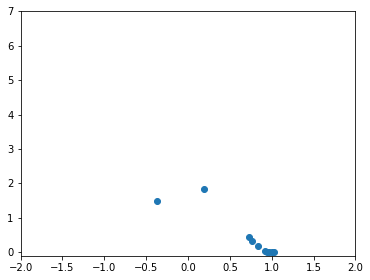

Langevin iteration 311
(10,)
Langevin iteration 312
(10,)
Langevin iteration 313
(10,)
Langevin iteration 314
(10,)
Langevin iteration 315
(10,)
Langevin iteration 316
(10,)
Langevin iteration 317
(10,)
Langevin iteration 318
(10,)
Langevin iteration 319
(10,)
Langevin iteration 320
(10,)


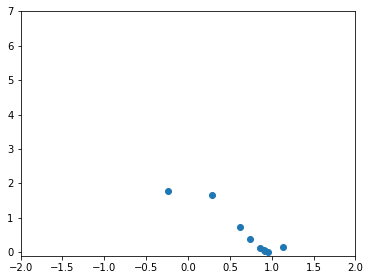

Langevin iteration 321
(10,)
Langevin iteration 322
(10,)
Langevin iteration 323
(10,)
Langevin iteration 324
(10,)
Langevin iteration 325
(10,)
Langevin iteration 326
(10,)
Langevin iteration 327
(10,)
Langevin iteration 328
(10,)
Langevin iteration 329
(10,)
Langevin iteration 330
(10,)


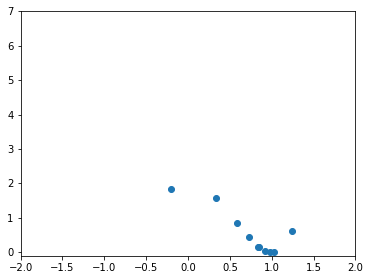

Langevin iteration 331
(10,)
Langevin iteration 332
(10,)
Langevin iteration 333
(10,)
Langevin iteration 334
(10,)
Langevin iteration 335
(10,)
Langevin iteration 336
(10,)
Langevin iteration 337
(10,)
Langevin iteration 338
(10,)
Langevin iteration 339
(10,)
Langevin iteration 340
(10,)


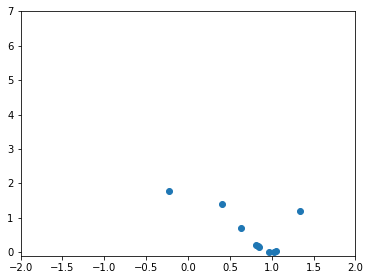

Langevin iteration 341
(10,)
Langevin iteration 342
(10,)
Langevin iteration 343
(10,)
Langevin iteration 344
(10,)
Langevin iteration 345
(10,)
Langevin iteration 346
(10,)
Langevin iteration 347
(10,)
Langevin iteration 348
(10,)
Langevin iteration 349
(10,)
Langevin iteration 350
(10,)


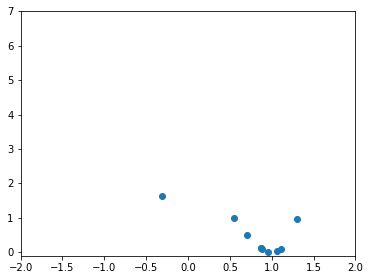

Langevin iteration 351
(10,)
Langevin iteration 352
(10,)
Langevin iteration 353
(10,)
Langevin iteration 354
(10,)
Langevin iteration 355
(10,)
Langevin iteration 356
(10,)
Langevin iteration 357
(10,)
Langevin iteration 358
(10,)
Langevin iteration 359
(10,)
Langevin iteration 360
(10,)


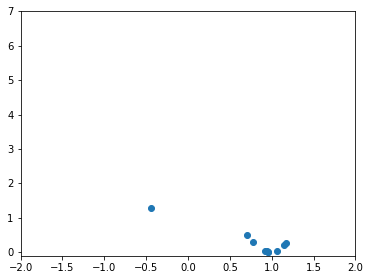

Langevin iteration 361
(10,)
Langevin iteration 362
(10,)
Langevin iteration 363
(10,)
Langevin iteration 364
(10,)
Langevin iteration 365
(10,)
Langevin iteration 366
(10,)
Langevin iteration 367
(10,)
Langevin iteration 368
(10,)
Langevin iteration 369
(10,)
Langevin iteration 370
(10,)


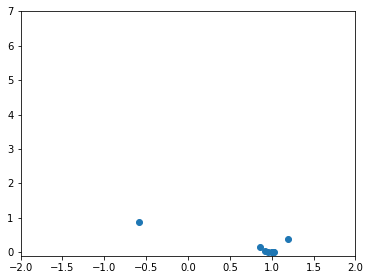

Langevin iteration 371
(10,)
Langevin iteration 372
(10,)
Langevin iteration 373
(10,)
Langevin iteration 374
(10,)
Langevin iteration 375
(10,)
Langevin iteration 376
(10,)
Langevin iteration 377
(10,)
Langevin iteration 378
(10,)
Langevin iteration 379
(10,)
Langevin iteration 380
(10,)


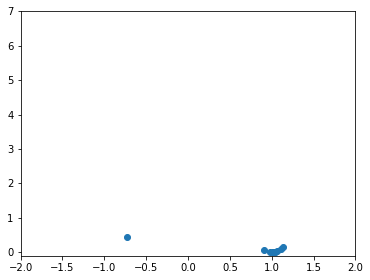

Langevin iteration 381
(10,)
Langevin iteration 382
(10,)
Langevin iteration 383
(10,)
Langevin iteration 384
(10,)
Langevin iteration 385
(10,)
Langevin iteration 386
(10,)
Langevin iteration 387
(10,)
Langevin iteration 388
(10,)
Langevin iteration 389
(10,)
Langevin iteration 390
(10,)


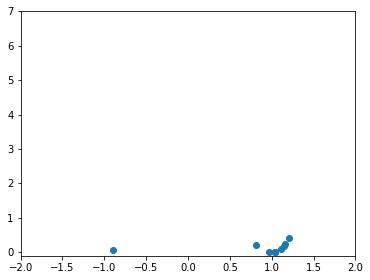

Langevin iteration 391
(10,)
Langevin iteration 392
(10,)
Langevin iteration 393
(10,)
Langevin iteration 394
(10,)
Langevin iteration 395
(10,)
Langevin iteration 396
(10,)
Langevin iteration 397
(10,)
Langevin iteration 398
(10,)
Langevin iteration 399
(10,)
Langevin iteration 400
(10,)


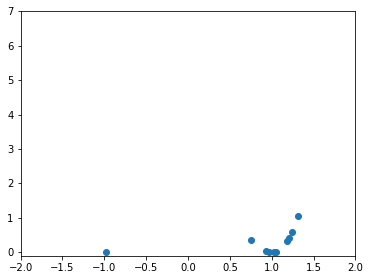

Langevin iteration 401
(10,)
Langevin iteration 402
(10,)
Langevin iteration 403
(10,)
Langevin iteration 404
(10,)
Langevin iteration 405
(10,)
Langevin iteration 406
(10,)
Langevin iteration 407
(10,)
Langevin iteration 408
(10,)
Langevin iteration 409
(10,)
Langevin iteration 410
(10,)


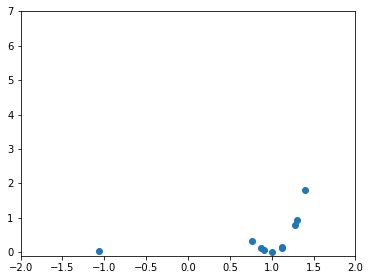

Langevin iteration 411
(10,)
Langevin iteration 412
(10,)
Langevin iteration 413
(10,)
Langevin iteration 414
(10,)
Langevin iteration 415
(10,)
Langevin iteration 416
(10,)
Langevin iteration 417
(10,)
Langevin iteration 418
(10,)
Langevin iteration 419
(10,)
Langevin iteration 420
(10,)


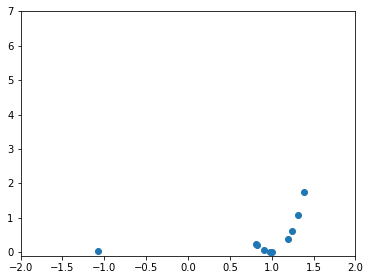

Langevin iteration 421
(10,)
Langevin iteration 422
(10,)
Langevin iteration 423
(10,)
Langevin iteration 424
(10,)
Langevin iteration 425
(10,)
Langevin iteration 426
(10,)
Langevin iteration 427
(10,)
Langevin iteration 428
(10,)
Langevin iteration 429
(10,)
Langevin iteration 430
(10,)


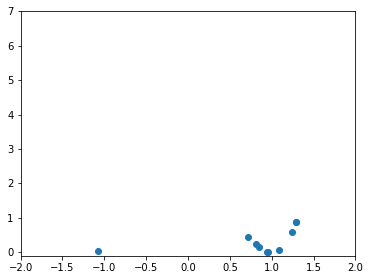

Langevin iteration 431
(10,)
Langevin iteration 432
(10,)
Langevin iteration 433
(10,)
Langevin iteration 434
(10,)
Langevin iteration 435
(10,)
Langevin iteration 436
(10,)
Langevin iteration 437
(10,)
Langevin iteration 438
(10,)
Langevin iteration 439
(10,)
Langevin iteration 440
(10,)


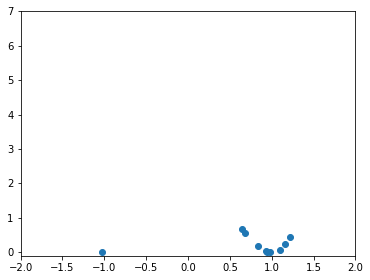

Langevin iteration 441
(10,)
Langevin iteration 442
(10,)
Langevin iteration 443
(10,)
Langevin iteration 444
(10,)
Langevin iteration 445
(10,)
Langevin iteration 446
(10,)
Langevin iteration 447
(10,)
Langevin iteration 448
(10,)
Langevin iteration 449
(10,)
Langevin iteration 450
(10,)


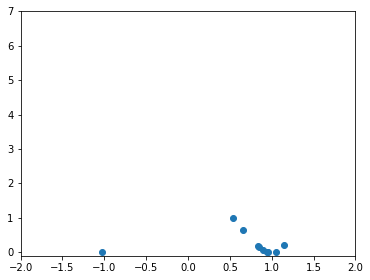

Langevin iteration 451
(10,)
Langevin iteration 452
(10,)
Langevin iteration 453
(10,)
Langevin iteration 454
(10,)
Langevin iteration 455
(10,)
Langevin iteration 456
(10,)
Langevin iteration 457
(10,)
Langevin iteration 458
(10,)
Langevin iteration 459
(10,)
Langevin iteration 460
(10,)


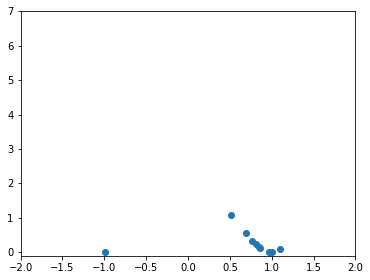

Langevin iteration 461
(10,)
Langevin iteration 462
(10,)
Langevin iteration 463
(10,)
Langevin iteration 464
(10,)
Langevin iteration 465
(10,)
Langevin iteration 466
(10,)
Langevin iteration 467
(10,)
Langevin iteration 468
(10,)
Langevin iteration 469
(10,)
Langevin iteration 470
(10,)


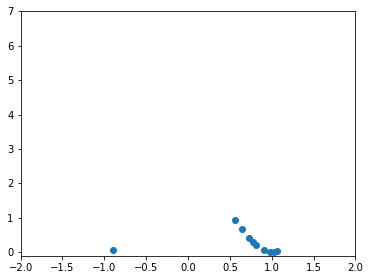

Langevin iteration 471
(10,)
Langevin iteration 472
(10,)
Langevin iteration 473
(10,)
Langevin iteration 474
(10,)
Langevin iteration 475
(10,)
Langevin iteration 476
(10,)
Langevin iteration 477
(10,)
Langevin iteration 478
(10,)
Langevin iteration 479
(10,)
Langevin iteration 480
(10,)


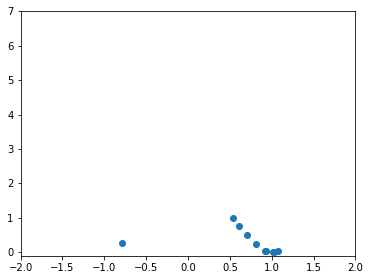

Langevin iteration 481
(10,)
Langevin iteration 482
(10,)
Langevin iteration 483
(10,)
Langevin iteration 484
(10,)
Langevin iteration 485
(10,)
Langevin iteration 486
(10,)
Langevin iteration 487
(10,)
Langevin iteration 488
(10,)
Langevin iteration 489
(10,)
Langevin iteration 490
(10,)


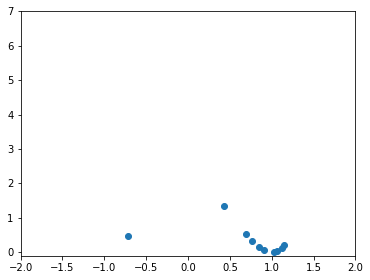

Langevin iteration 491
(10,)
Langevin iteration 492
(10,)
Langevin iteration 493
(10,)
Langevin iteration 494
(10,)
Langevin iteration 495
(10,)
Langevin iteration 496
(10,)
Langevin iteration 497
(10,)
Langevin iteration 498
(10,)
Langevin iteration 499
(10,)
Langevin iteration 500
(10,)


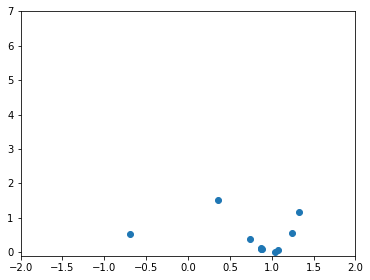

Langevin iteration 501
(10,)
Langevin iteration 502
(10,)
Langevin iteration 503
(10,)
Langevin iteration 504
(10,)
Langevin iteration 505
(10,)
Langevin iteration 506
(10,)
Langevin iteration 507
(10,)
Langevin iteration 508
(10,)
Langevin iteration 509
(10,)
Langevin iteration 510
(10,)


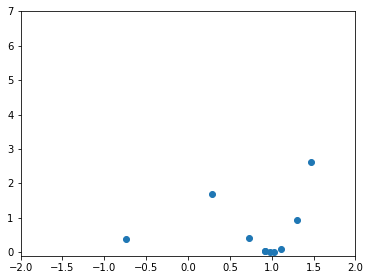

Langevin iteration 511
(10,)
Langevin iteration 512
(10,)
Langevin iteration 513
(10,)
Langevin iteration 514
(10,)
Langevin iteration 515
(10,)
Langevin iteration 516
(10,)
Langevin iteration 517
(10,)
Langevin iteration 518
(10,)
Langevin iteration 519
(10,)
Langevin iteration 520
(10,)


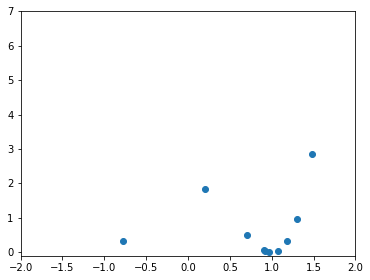

Langevin iteration 521
(10,)
Langevin iteration 522
(10,)
Langevin iteration 523
(10,)
Langevin iteration 524
(10,)
Langevin iteration 525
(10,)
Langevin iteration 526
(10,)
Langevin iteration 527
(10,)
Langevin iteration 528
(10,)
Langevin iteration 529
(10,)
Langevin iteration 530
(10,)


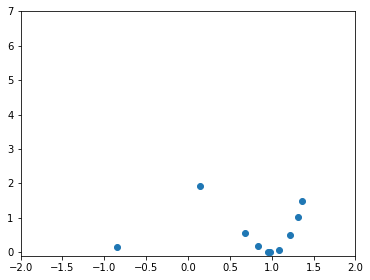

Langevin iteration 531
(10,)
Langevin iteration 532
(10,)
Langevin iteration 533
(10,)
Langevin iteration 534
(10,)
Langevin iteration 535
(10,)
Langevin iteration 536
(10,)
Langevin iteration 537
(10,)
Langevin iteration 538
(10,)
Langevin iteration 539
(10,)
Langevin iteration 540
(10,)


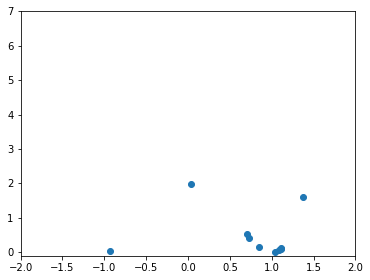

Langevin iteration 541
(10,)
Langevin iteration 542
(10,)
Langevin iteration 543
(10,)
Langevin iteration 544
(10,)
Langevin iteration 545
(10,)
Langevin iteration 546
(10,)
Langevin iteration 547
(10,)
Langevin iteration 548
(10,)
Langevin iteration 549
(10,)
Langevin iteration 550
(10,)


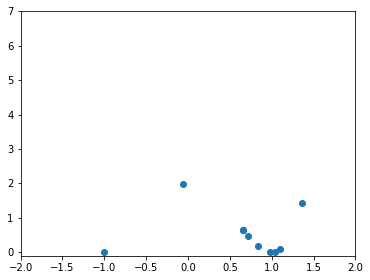

Langevin iteration 551
(10,)
Langevin iteration 552
(10,)
Langevin iteration 553
(10,)
Langevin iteration 554
(10,)
Langevin iteration 555
(10,)
Langevin iteration 556
(10,)
Langevin iteration 557
(10,)
Langevin iteration 558
(10,)
Langevin iteration 559
(10,)
Langevin iteration 560
(10,)


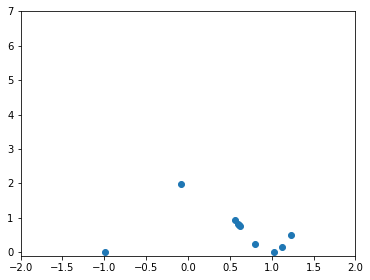

Langevin iteration 561
(10,)
Langevin iteration 562
(10,)
Langevin iteration 563
(10,)
Langevin iteration 564
(10,)
Langevin iteration 565
(10,)
Langevin iteration 566
(10,)
Langevin iteration 567
(10,)
Langevin iteration 568
(10,)
Langevin iteration 569
(10,)
Langevin iteration 570
(10,)


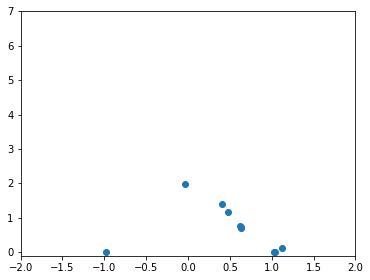

Langevin iteration 571
(10,)
Langevin iteration 572
(10,)
Langevin iteration 573
(10,)
Langevin iteration 574
(10,)
Langevin iteration 575
(10,)
Langevin iteration 576
(10,)
Langevin iteration 577
(10,)
Langevin iteration 578
(10,)
Langevin iteration 579
(10,)
Langevin iteration 580
(10,)


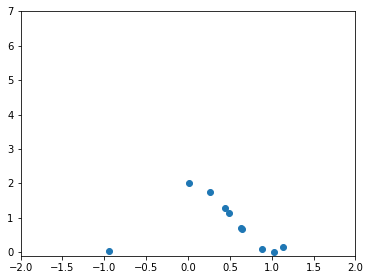

Langevin iteration 581
(10,)
Langevin iteration 582
(10,)
Langevin iteration 583
(10,)
Langevin iteration 584
(10,)
Langevin iteration 585
(10,)
Langevin iteration 586
(10,)
Langevin iteration 587
(10,)
Langevin iteration 588
(10,)
Langevin iteration 589
(10,)
Langevin iteration 590
(10,)


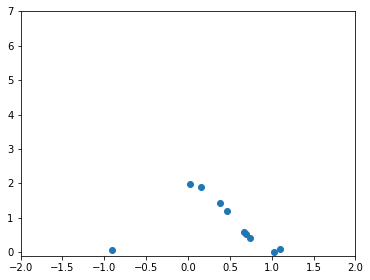

Langevin iteration 591
(10,)
Langevin iteration 592
(10,)
Langevin iteration 593
(10,)
Langevin iteration 594
(10,)
Langevin iteration 595
(10,)
Langevin iteration 596
(10,)
Langevin iteration 597
(10,)
Langevin iteration 598
(10,)
Langevin iteration 599
(10,)
Langevin iteration 600
(10,)


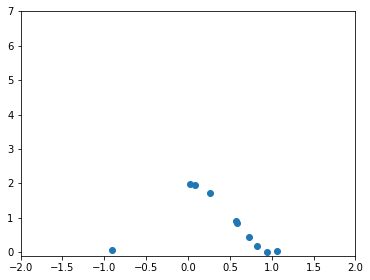

Langevin iteration 601
(10,)
Langevin iteration 602
(10,)
Langevin iteration 603
(10,)
Langevin iteration 604
(10,)
Langevin iteration 605
(10,)
Langevin iteration 606
(10,)
Langevin iteration 607
(10,)
Langevin iteration 608
(10,)
Langevin iteration 609
(10,)
Langevin iteration 610
(10,)


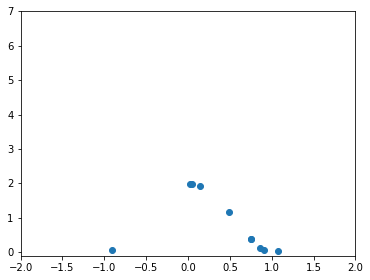

Langevin iteration 611
(10,)
Langevin iteration 612
(10,)
Langevin iteration 613
(10,)
Langevin iteration 614
(10,)
Langevin iteration 615
(10,)
Langevin iteration 616
(10,)
Langevin iteration 617
(10,)
Langevin iteration 618
(10,)
Langevin iteration 619
(10,)
Langevin iteration 620
(10,)


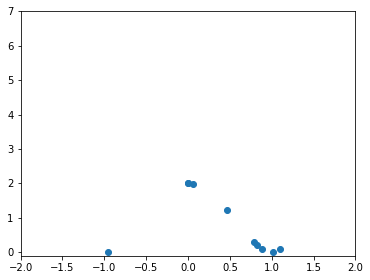

Langevin iteration 621
(10,)
Langevin iteration 622
(10,)
Langevin iteration 623
(10,)
Langevin iteration 624
(10,)
Langevin iteration 625
(10,)
Langevin iteration 626
(10,)
Langevin iteration 627
(10,)
Langevin iteration 628
(10,)
Langevin iteration 629
(10,)
Langevin iteration 630
(10,)


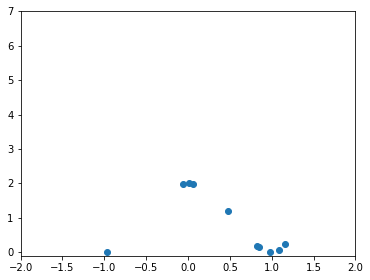

Langevin iteration 631
(10,)
Langevin iteration 632
(10,)
Langevin iteration 633
(10,)
Langevin iteration 634
(10,)
Langevin iteration 635
(10,)
Langevin iteration 636
(10,)
Langevin iteration 637
(10,)
Langevin iteration 638
(10,)
Langevin iteration 639
(10,)
Langevin iteration 640
(10,)


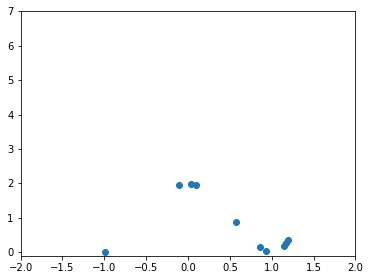

Langevin iteration 641
(10,)
Langevin iteration 642
(10,)
Langevin iteration 643
(10,)
Langevin iteration 644
(10,)
Langevin iteration 645
(10,)
Langevin iteration 646
(10,)
Langevin iteration 647
(10,)
Langevin iteration 648
(10,)
Langevin iteration 649
(10,)
Langevin iteration 650
(10,)


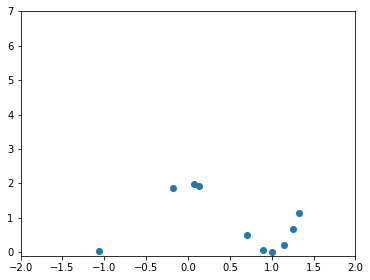

Langevin iteration 651
(10,)
Langevin iteration 652
(10,)
Langevin iteration 653
(10,)
Langevin iteration 654
(10,)
Langevin iteration 655
(10,)
Langevin iteration 656
(10,)
Langevin iteration 657
(10,)
Langevin iteration 658
(10,)
Langevin iteration 659
(10,)
Langevin iteration 660
(10,)


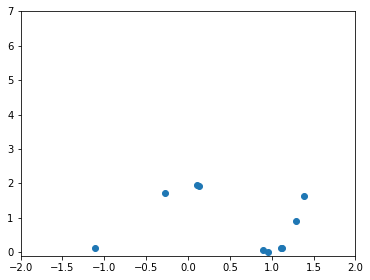

Langevin iteration 661
(10,)
Langevin iteration 662
(10,)
Langevin iteration 663
(10,)
Langevin iteration 664
(10,)
Langevin iteration 665
(10,)
Langevin iteration 666
(10,)
Langevin iteration 667
(10,)
Langevin iteration 668
(10,)
Langevin iteration 669
(10,)
Langevin iteration 670
(10,)


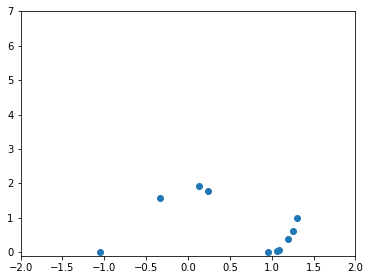

Langevin iteration 671
(10,)
Langevin iteration 672
(10,)
Langevin iteration 673
(10,)
Langevin iteration 674
(10,)
Langevin iteration 675
(10,)
Langevin iteration 676
(10,)
Langevin iteration 677
(10,)
Langevin iteration 678
(10,)
Langevin iteration 679
(10,)
Langevin iteration 680
(10,)


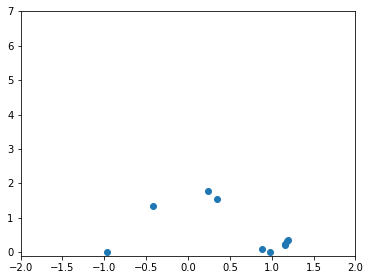

Langevin iteration 681
(10,)
Langevin iteration 682
(10,)
Langevin iteration 683
(10,)
Langevin iteration 684
(10,)
Langevin iteration 685
(10,)
Langevin iteration 686
(10,)
Langevin iteration 687
(10,)
Langevin iteration 688
(10,)
Langevin iteration 689
(10,)
Langevin iteration 690
(10,)


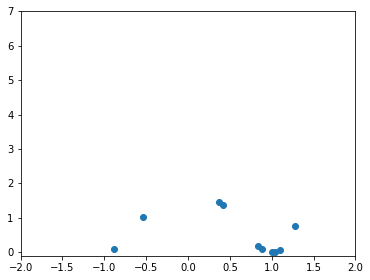

Langevin iteration 691
(10,)
Langevin iteration 692
(10,)
Langevin iteration 693
(10,)
Langevin iteration 694
(10,)
Langevin iteration 695
(10,)
Langevin iteration 696
(10,)
Langevin iteration 697
(10,)
Langevin iteration 698
(10,)
Langevin iteration 699
(10,)
Langevin iteration 700
(10,)


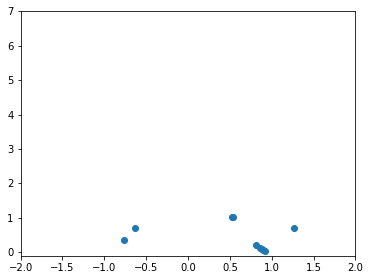

Langevin iteration 701
(10,)
Langevin iteration 702
(10,)
Langevin iteration 703
(10,)
Langevin iteration 704
(10,)
Langevin iteration 705
(10,)
Langevin iteration 706
(10,)
Langevin iteration 707
(10,)
Langevin iteration 708
(10,)
Langevin iteration 709
(10,)
Langevin iteration 710
(10,)


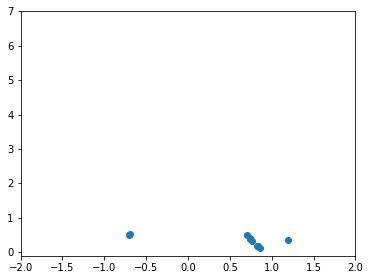

Langevin iteration 711
(10,)
Langevin iteration 712
(10,)
Langevin iteration 713
(10,)
Langevin iteration 714
(10,)
Langevin iteration 715
(10,)
Langevin iteration 716
(10,)
Langevin iteration 717
(10,)
Langevin iteration 718
(10,)
Langevin iteration 719
(10,)
Langevin iteration 720
(10,)


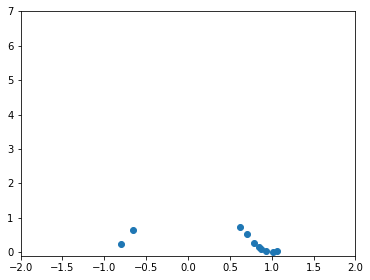

Langevin iteration 721
(10,)
Langevin iteration 722
(10,)
Langevin iteration 723
(10,)
Langevin iteration 724
(10,)
Langevin iteration 725
(10,)
Langevin iteration 726
(10,)
Langevin iteration 727
(10,)
Langevin iteration 728
(10,)
Langevin iteration 729
(10,)
Langevin iteration 730
(10,)


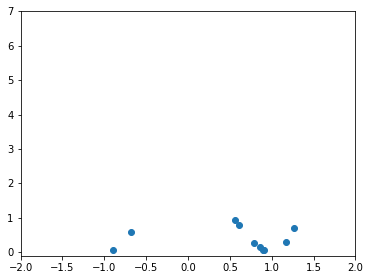

Langevin iteration 731
(10,)
Langevin iteration 732
(10,)
Langevin iteration 733
(10,)
Langevin iteration 734
(10,)
Langevin iteration 735
(10,)
Langevin iteration 736
(10,)
Langevin iteration 737
(10,)
Langevin iteration 738
(10,)
Langevin iteration 739
(10,)
Langevin iteration 740
(10,)


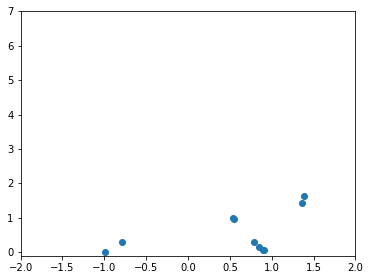

Langevin iteration 741
(10,)
Langevin iteration 742
(10,)
Langevin iteration 743
(10,)
Langevin iteration 744
(10,)
Langevin iteration 745
(10,)
Langevin iteration 746
(10,)
Langevin iteration 747
(10,)
Langevin iteration 748
(10,)
Langevin iteration 749
(10,)
Langevin iteration 750
(10,)


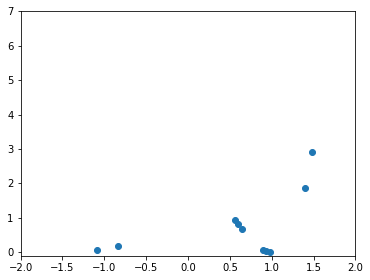

Langevin iteration 751
(10,)
Langevin iteration 752
(10,)
Langevin iteration 753
(10,)
Langevin iteration 754
(10,)
Langevin iteration 755
(10,)
Langevin iteration 756
(10,)
Langevin iteration 757
(10,)
Langevin iteration 758
(10,)
Langevin iteration 759
(10,)
Langevin iteration 760
(10,)


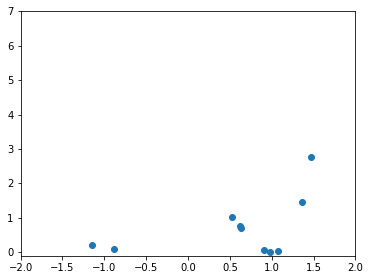

Langevin iteration 761
(10,)
Langevin iteration 762
(10,)
Langevin iteration 763
(10,)
Langevin iteration 764
(10,)
Langevin iteration 765
(10,)
Langevin iteration 766
(10,)
Langevin iteration 767
(10,)
Langevin iteration 768
(10,)
Langevin iteration 769
(10,)
Langevin iteration 770
(10,)


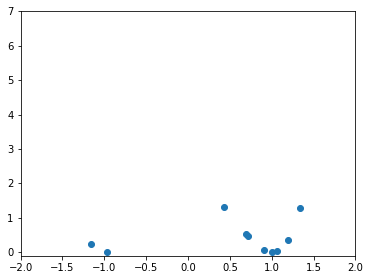

Langevin iteration 771
(10,)
Langevin iteration 772
(10,)
Langevin iteration 773
(10,)
Langevin iteration 774
(10,)
Langevin iteration 775
(10,)
Langevin iteration 776
(10,)
Langevin iteration 777
(10,)
Langevin iteration 778
(10,)
Langevin iteration 779
(10,)
Langevin iteration 780
(10,)


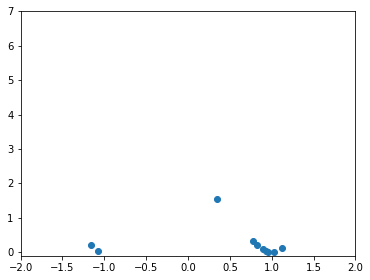

Langevin iteration 781
(10,)
Langevin iteration 782
(10,)
Langevin iteration 783
(10,)
Langevin iteration 784
(10,)
Langevin iteration 785
(10,)
Langevin iteration 786
(10,)
Langevin iteration 787
(10,)
Langevin iteration 788
(10,)
Langevin iteration 789
(10,)
Langevin iteration 790
(10,)


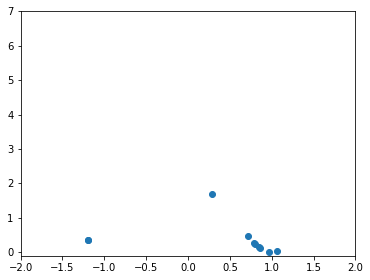

Langevin iteration 791
(10,)
Langevin iteration 792
(10,)
Langevin iteration 793
(10,)
Langevin iteration 794
(10,)
Langevin iteration 795
(10,)
Langevin iteration 796
(10,)
Langevin iteration 797
(10,)
Langevin iteration 798
(10,)
Langevin iteration 799
(10,)
Langevin iteration 800
(10,)


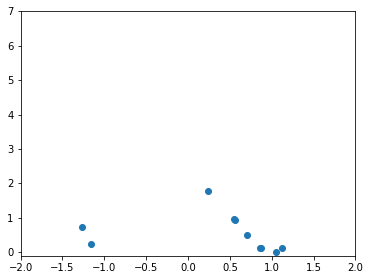

Langevin iteration 801
(10,)
Langevin iteration 802
(10,)
Langevin iteration 803
(10,)
Langevin iteration 804
(10,)
Langevin iteration 805
(10,)
Langevin iteration 806
(10,)
Langevin iteration 807
(10,)
Langevin iteration 808
(10,)
Langevin iteration 809
(10,)
Langevin iteration 810
(10,)


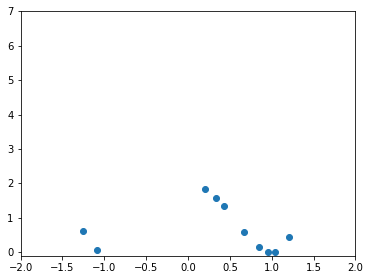

Langevin iteration 811
(10,)
Langevin iteration 812
(10,)
Langevin iteration 813
(10,)
Langevin iteration 814
(10,)
Langevin iteration 815
(10,)
Langevin iteration 816
(10,)
Langevin iteration 817
(10,)
Langevin iteration 818
(10,)
Langevin iteration 819
(10,)
Langevin iteration 820
(10,)


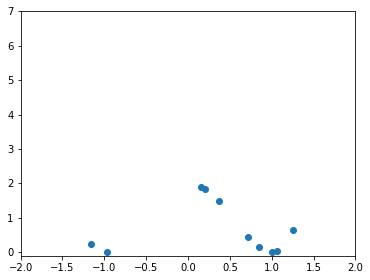

Langevin iteration 821
(10,)
Langevin iteration 822
(10,)
Langevin iteration 823
(10,)
Langevin iteration 824
(10,)
Langevin iteration 825
(10,)
Langevin iteration 826
(10,)
Langevin iteration 827
(10,)
Langevin iteration 828
(10,)
Langevin iteration 829
(10,)
Langevin iteration 830
(10,)


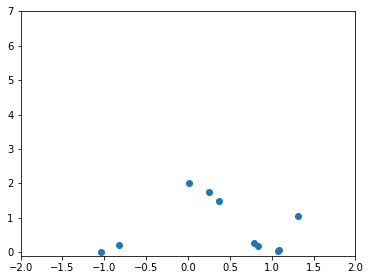

Langevin iteration 831
(10,)
Langevin iteration 832
(10,)
Langevin iteration 833
(10,)
Langevin iteration 834
(10,)
Langevin iteration 835
(10,)
Langevin iteration 836
(10,)
Langevin iteration 837
(10,)
Langevin iteration 838
(10,)
Langevin iteration 839
(10,)
Langevin iteration 840
(10,)


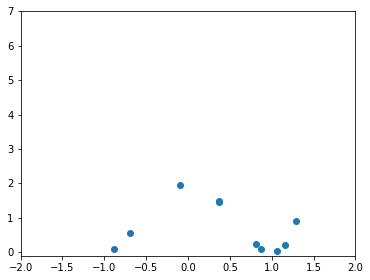

Langevin iteration 841
(10,)
Langevin iteration 842
(10,)
Langevin iteration 843
(10,)
Langevin iteration 844
(10,)
Langevin iteration 845
(10,)
Langevin iteration 846
(10,)
Langevin iteration 847
(10,)
Langevin iteration 848
(10,)
Langevin iteration 849
(10,)
Langevin iteration 850
(10,)


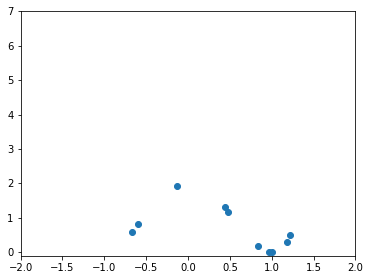

Langevin iteration 851
(10,)
Langevin iteration 852
(10,)
Langevin iteration 853
(10,)
Langevin iteration 854
(10,)
Langevin iteration 855
(10,)
Langevin iteration 856
(10,)
Langevin iteration 857
(10,)
Langevin iteration 858
(10,)
Langevin iteration 859
(10,)
Langevin iteration 860
(10,)


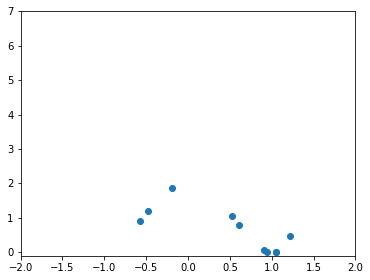

Langevin iteration 861
(10,)
Langevin iteration 862
(10,)
Langevin iteration 863
(10,)
Langevin iteration 864
(10,)
Langevin iteration 865
(10,)
Langevin iteration 866
(10,)
Langevin iteration 867
(10,)
Langevin iteration 868
(10,)
Langevin iteration 869
(10,)
Langevin iteration 870
(10,)


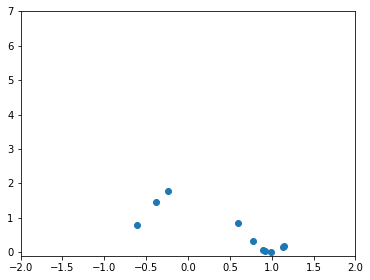

Langevin iteration 871
(10,)
Langevin iteration 872
(10,)
Langevin iteration 873
(10,)
Langevin iteration 874
(10,)
Langevin iteration 875
(10,)
Langevin iteration 876
(10,)
Langevin iteration 877
(10,)
Langevin iteration 878
(10,)
Langevin iteration 879
(10,)
Langevin iteration 880
(10,)


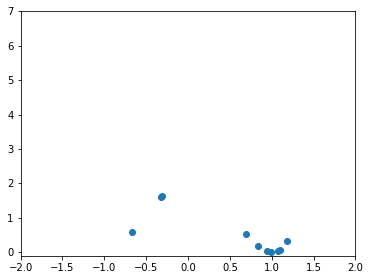

Langevin iteration 881
(10,)
Langevin iteration 882
(10,)
Langevin iteration 883
(10,)
Langevin iteration 884
(10,)
Langevin iteration 885
(10,)
Langevin iteration 886
(10,)
Langevin iteration 887
(10,)
Langevin iteration 888
(10,)
Langevin iteration 889
(10,)
Langevin iteration 890
(10,)


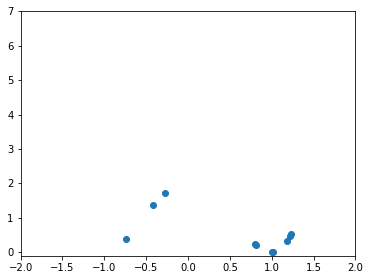

Langevin iteration 891
(10,)
Langevin iteration 892
(10,)
Langevin iteration 893
(10,)
Langevin iteration 894
(10,)
Langevin iteration 895
(10,)
Langevin iteration 896
(10,)
Langevin iteration 897
(10,)
Langevin iteration 898
(10,)
Langevin iteration 899
(10,)
Langevin iteration 900
(10,)


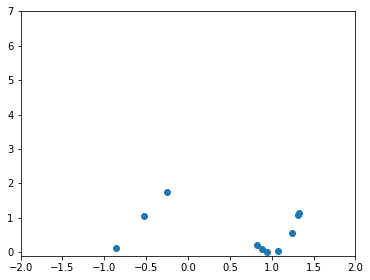

Langevin iteration 901
(10,)
Langevin iteration 902
(10,)
Langevin iteration 903
(10,)
Langevin iteration 904
(10,)
Langevin iteration 905
(10,)
Langevin iteration 906
(10,)
Langevin iteration 907
(10,)
Langevin iteration 908
(10,)
Langevin iteration 909
(10,)
Langevin iteration 910
(10,)


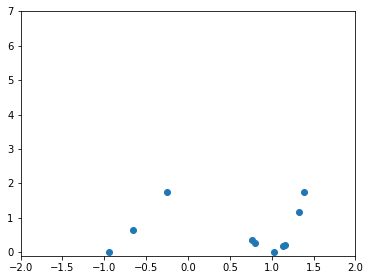

Langevin iteration 911
(10,)
Langevin iteration 912
(10,)
Langevin iteration 913
(10,)
Langevin iteration 914
(10,)
Langevin iteration 915
(10,)
Langevin iteration 916
(10,)
Langevin iteration 917
(10,)
Langevin iteration 918
(10,)
Langevin iteration 919
(10,)
Langevin iteration 920
(10,)


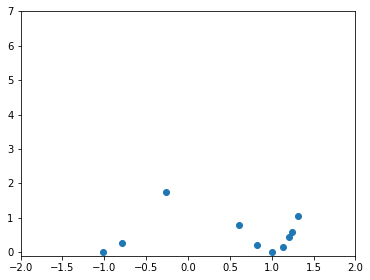

Langevin iteration 921
(10,)
Langevin iteration 922
(10,)
Langevin iteration 923
(10,)
Langevin iteration 924
(10,)
Langevin iteration 925
(10,)
Langevin iteration 926
(10,)
Langevin iteration 927
(10,)
Langevin iteration 928
(10,)
Langevin iteration 929
(10,)
Langevin iteration 930
(10,)


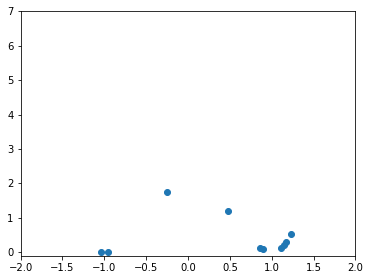

Langevin iteration 931
(10,)
Langevin iteration 932
(10,)
Langevin iteration 933
(10,)
Langevin iteration 934
(10,)
Langevin iteration 935
(10,)
Langevin iteration 936
(10,)
Langevin iteration 937
(10,)
Langevin iteration 938
(10,)
Langevin iteration 939
(10,)
Langevin iteration 940
(10,)


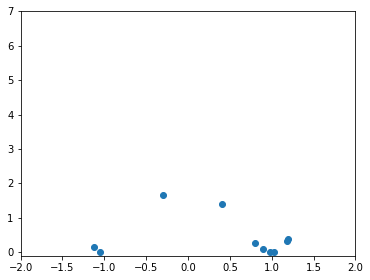

Langevin iteration 941
(10,)
Langevin iteration 942
(10,)
Langevin iteration 943
(10,)
Langevin iteration 944
(10,)
Langevin iteration 945
(10,)
Langevin iteration 946
(10,)
Langevin iteration 947
(10,)
Langevin iteration 948
(10,)
Langevin iteration 949
(10,)
Langevin iteration 950
(10,)


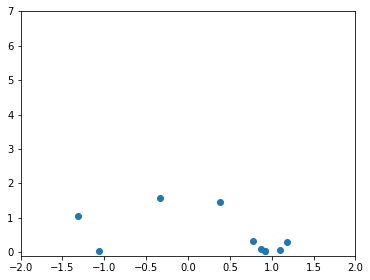

Langevin iteration 951
(10,)
Langevin iteration 952
(10,)
Langevin iteration 953
(10,)
Langevin iteration 954
(10,)
Langevin iteration 955
(10,)
Langevin iteration 956
(10,)
Langevin iteration 957
(10,)
Langevin iteration 958
(10,)
Langevin iteration 959
(10,)
Langevin iteration 960
(10,)


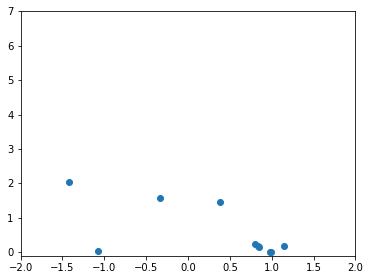

Langevin iteration 961
(10,)
Langevin iteration 962
(10,)
Langevin iteration 963
(10,)
Langevin iteration 964
(10,)
Langevin iteration 965
(10,)
Langevin iteration 966
(10,)
Langevin iteration 967
(10,)
Langevin iteration 968
(10,)
Langevin iteration 969
(10,)
Langevin iteration 970
(10,)


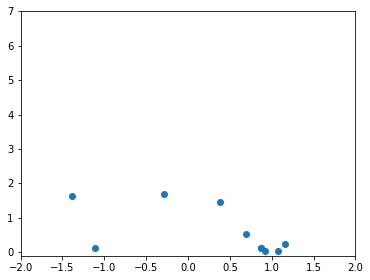

Langevin iteration 971
(10,)
Langevin iteration 972
(10,)
Langevin iteration 973
(10,)
Langevin iteration 974
(10,)
Langevin iteration 975
(10,)
Langevin iteration 976
(10,)
Langevin iteration 977
(10,)
Langevin iteration 978
(10,)
Langevin iteration 979
(10,)
Langevin iteration 980
(10,)


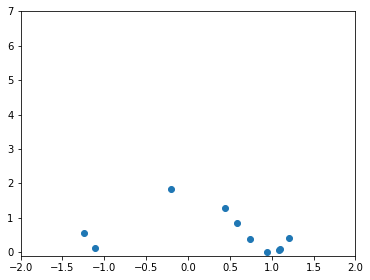

Langevin iteration 981
(10,)
Langevin iteration 982
(10,)
Langevin iteration 983
(10,)
Langevin iteration 984
(10,)
Langevin iteration 985
(10,)
Langevin iteration 986
(10,)
Langevin iteration 987
(10,)
Langevin iteration 988
(10,)
Langevin iteration 989
(10,)
Langevin iteration 990
(10,)


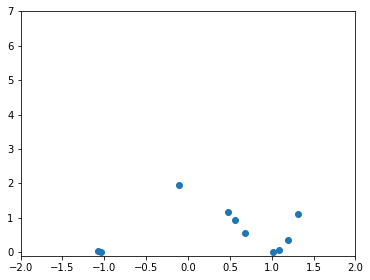

Langevin iteration 991
(10,)
Langevin iteration 992
(10,)
Langevin iteration 993
(10,)
Langevin iteration 994
(10,)
Langevin iteration 995
(10,)
Langevin iteration 996
(10,)
Langevin iteration 997
(10,)
Langevin iteration 998
(10,)
Langevin iteration 999
(10,)


In [16]:
numberOfSteinSteps = 1000#50000
modit=10
moditfig=10

gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))

X_short = np.copy(X0)
p = np.random.randn(*x.shape)

dt_step=0.01
mass = 1 

q = X_short

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
#f = compute_force_all(XL)

# modit = int(numberOfSteinSteps/20)
# moditfig = int(numberOfSteinSteps/20)
# KL = np.zeros(numberOfSteinSteps)
Obs_average = np.zeros(numberOfSteinSteps)
#f = compute_force_all(XL)


states_evolution_Langevin=[]

for ns in range(numberOfSteinSteps):
    #if ns%modit==0:
    print('Langevin iteration '+repr(ns))
    #f = compute_force_all(XL)
    q, p = Langevin_step(q, p, dt_step) #(XL + epsilon_step * f)#/mass );
    print(q.shape)
    states_evolution_Langevin.append(np.copy(q))
    #while(1):
    #    pass
    #q =  np.copy(XL)
    #q_density = q_density / abs(1.0 + epsilon_step*grad_force)
    
    #weights = np.exp(-energy(q)) / q_density
    #KL[ns] = np.mean(np.log(weights))
    #Obs_average[ns] = np.sum(weights*q) / np.sum(weights)
    #print(q.shape)
    Obs_average[ns] = np.mean(q)
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure=None)
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

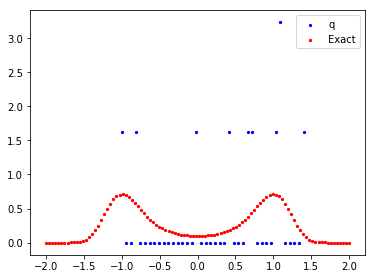

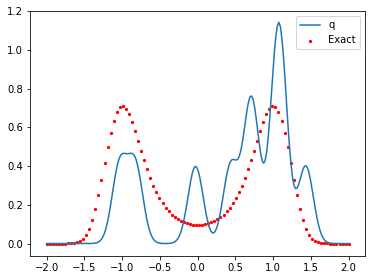

In [17]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)
x = q
data, bins = np.histogram(x, 40, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
xx = np.linspace(-2,2,100)
Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
ax.scatter(bin_centers, data , c='b', s=5)
ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.legend(['q','Exact' ])
plt.show()

from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(q.reshape(-1,1))

X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

fig = plt.figure(figsize=(6,4.5))
plt.plot(X_plot[:, 0], np.exp(log_dens), '-')
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.legend(['q','Exact' ])
plt.show()

In [18]:
Z = 1.973732150#0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X0))
print(np.mean(q))
print('************')

print('E[V(x)] = .4172545129')#0.5247724179')
print(np.mean(energy(X0)))
print(np.mean(energy(q)))
print('************')

print('E[-f(x)*x] = 1')
print(np.mean((-force(X0)* X0)))
print((np.mean(-force(q)* q)))

Z=1.97373215
E[x] = 0
0.768349642104
0.46345913053
************
E[V(x)] = .4172545129
0.357140434785
0.688559445711
************
E[-f(x)*x] = 1
-1.79546731782
1.5358046315


In [19]:
# import pandas as pd
# df_Langevin = pd.DataFrame(data=q)

# from pandas.plotting import autocorrelation_plot


# Lag=np.arange(0, 10)
# print(Lag)
# plt.figure()

# data = pd.Series(q)

# acf = np.zeros(len(Lag))
# for i in range(len(Lag)):
#     acf[i] = data.autocorr(lag=Lag[i])
# print(acf)
# plt.plot(Lag, acf)
# plt.show()

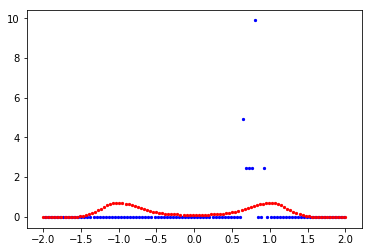

In [20]:
xx = np.linspace(-2,2,100)
data, bins = np.histogram(X0, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
plt.scatter(bin_centers, data , c='b', s=5)
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/initial_distribution.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()




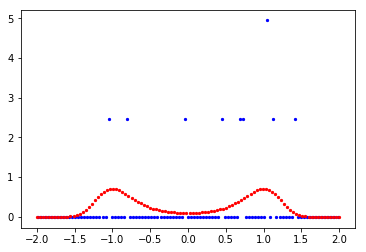

2.31095884747


In [21]:


xx = np.linspace(-2,2,100)
data, bins = np.histogram(x, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
plt.scatter(bin_centers, data , c='b', s=5)
plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.show()


hist_exact=np.exp(- energy(xx))/Z 
print(np.linalg.norm(hist_exact[:-1] - data)/np.linalg.norm(hist_exact[:-1] ))
err_stein=np.zeros(numberOfSteinSteps)
err_langevin=np.zeros(numberOfSteinSteps)
for n in range(numberOfSteinSteps):
    
    q_curr_stein = states_evolution_stein[n]

    q_curr_langevin = states_evolution_Langevin[n]
    
    data_stein, bins = np.histogram(q_curr_stein, xx, density=True)
    data_langevin, bins = np.histogram(q_curr_langevin, xx, density=True)
    
    err_stein[n] = np.linalg.norm(hist_exact[:-1] - data_stein)/np.linalg.norm(hist_exact[:-1] )
    err_langevin[n] = np.linalg.norm(hist_exact[:-1] - data_langevin)/np.linalg.norm(hist_exact[:-1] )


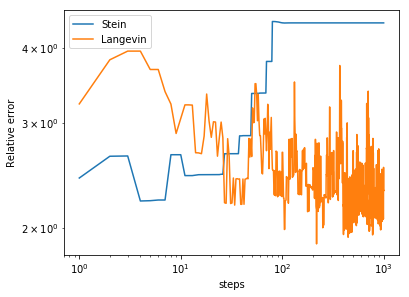

In [22]:
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

ax.loglog(range(numberOfSteinSteps), err_stein)
ax.loglog(range(numberOfSteinSteps), err_langevin)
ax.legend(['Stein','Langevin'])
ax.set_xlabel('steps')
ax.set_ylabel('Relative error')
plt.savefig('SteinFigures/h'+repr(h1)+'/error.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

2.31095884747


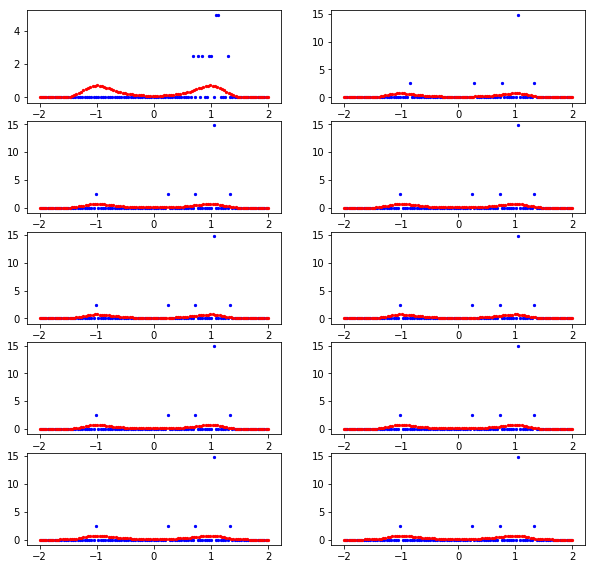

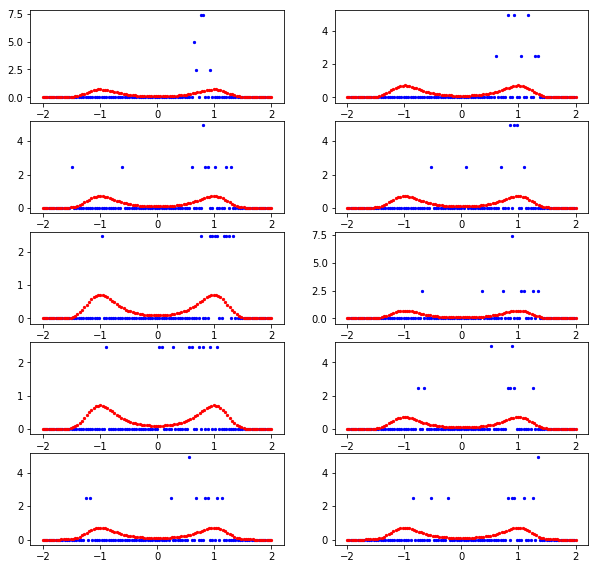

In [23]:
modnr=100
xx = np.linspace(-2,2,100)
data, bins = np.histogram(x, xx, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

Z = sum(np.exp(-energy(xx))) * (xx[1]-xx[0])
# plt.scatter(bin_centers, data , c='b', s=5)
# plt.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
# plt.show()


hist_exact=np.exp(- energy(xx))/Z 
print(np.linalg.norm(hist_exact[:-1] - data)/np.linalg.norm(hist_exact[:-1] ))
err_stein=np.zeros(numberOfSteinSteps)
err_langevin=np.zeros(numberOfSteinSteps)

fig = plt.figure(figsize=(10,20))
nrrows=10
i=0

for n in range(numberOfSteinSteps):
    q_curr_stein = states_evolution_stein[n]
    
    data_stein, bins = np.histogram(q_curr_stein, xx, density=True)
 
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    if n%modnr==0:
        
        
        ax = fig.add_subplot(nrrows, 2 ,i+1)
        i+=1
        
        ax.scatter(bin_centers, data_stein , c='b', s=5)
        ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/Stein.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,20))
nrrows=10
i=0

for n in range(numberOfSteinSteps):

    q_curr_langevin = states_evolution_Langevin[n]
    
    
    data_langevin, bins = np.histogram(q_curr_langevin, xx, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    if n%modnr==0:
        
        
        ax = fig.add_subplot(nrrows, 2 ,i+1)
        i+=1
        
        ax.scatter(bin_centers, data_langevin , c='b', s=5)
        ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
plt.savefig('SteinFigures/h'+repr(h1)+'/Langevin.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()
    


In [24]:
# import glob
# import moviepy.editor as mpy

# gif_name = 'SteinFigures/h'+repr(h1)+'/gif/Langevin/langevin'
# fps = 1
# file_list = glob.glob('SteinFigures/h'+repr(h1)+'/gif/Langevin/*.png') # Get all the pngs in the current directory
# #list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
# clip = mpy.ImageSequenceClip(file_list, fps=fps)
# clip.write_gif('{}.gif'.format(gif_name), fps=fps)

In [25]:
np.save('SteinFigures/h'+repr(h1)+'/langevin_data.npy',states_evolution_Langevin)
np.save('SteinFigures/h'+repr(h1)+'/stein_data.npy',states_evolution_stein)